# Data Prep

In [1]:
import pandas as pd
import numpy as np

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('wordnet')
# nltk.download('omw-1.4')


from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# text basic cleaning

In [25]:
# replace id with other artists
artist_id_ = 80199440

In [26]:
#whole dataframe
def get_data(artist_id_input):
    total_df = pd.read_csv('gg_final_dataframe.csv')
#     total_df = pd.read_csv('boygroup_final_dataframe2.csv')
    df = total_df[total_df['artist_id']==int(artist_id_input)][['artist_x', 'song_name', 'year', 'Lyric']]
    return df


def basic_cleaning(artist_id):
    
    df = get_data(artist_id)
        
    def clean_text(text):

        manual_sw = ['im', 'youre', "n't", '내', '나를', '나의', '너의', '난', '날', '내가', '너','나', '그', '니', '걸', '거야', '수', '다', '더',
    '널', '네', '니가', '네가', '널', '너를', '넌', '내게', '이', 'l', 'u', '-',
    'na', 'ah', 'e','m', 'uh', 'eh', 's', 'la', 'a', 'o', 'ta', 't', 'oh', 'du', 'yeah', '’', 'amp', 'comp',
    'tu', 'ye', 'it', 'i', 'but', '너무', 'so', 'in', '또', 'roob', '왔니', '조금', '꼭', '이렇게',
    'bo', 'peep', 'the','lolli', '정말', 'for', 'lollipop', '이제', 'on', 'muzik', 'lets', 'about', 
    '처', 'amoled', '좀', '두', '닷닷닷닷닷', '어쩌다', '4', 'is', 'and', 'to', 'you', 'me','huh', 'now', 'ooop',
    'just', 're', 'jumpin', 'dori', 'let', 'one', '아', 'ma', 'take', 'its', 'woo', 'this', 'that',
    'whoo', 'get', 'are', 'dovey', 'hey', '어머어머', 'hush', '오', '나는', '너는', '슈가프리', '자꾸', '위', '아래', '것', '있어', '같아', '돼', 'ya', 'tickle', 'ha',
    'way', '싶어', '같은', '오늘', '딱', '않아', '마', 'poppy','같아', 'day', 'be', 'rollin', '게', 'ba', 'hoo', 'ey', 'pa', 'ooh', 'swan', 'woo', 'ill', 'da', 'zu',
    'zim', 'dam', 'dda', 'got', 'umpah','안', '건', '할','것도', 'at', 'yah', 'all', 'with', 'ae']


        #changing to lowercase
        text = text.lower()
        text = text.replace('\r','')

        # removing #´s 
        text = re.sub(r'#[A-Za-z0-9]+', '', text)
        text = re.sub(r'#', '', text)

        #indentation -> space
        text = re.sub(r'\n', ' ', text)

        for punctuation in string.punctuation:
            text = text.replace(punctuation, '') 

        #strip
        text = text.strip()

        #tokenization
        tokens = word_tokenize(text)   
        filtered_words = [w for w in tokens if w not in manual_sw]
        final = " ".join(cat for cat in filtered_words)

        return final

    def kor_to_eng(text):
        
        #love related
        text = text.replace("사랑", "love")
        text = text.replace("좋아", "like") # like has multiple meanings, so needs to n-gram as well
        text = text.replace("키스", "kiss")
        text = text.replace("입맞", "kiss")
        text = text.replace("뽀뽀", "kiss")
        text = text.replace("터치", 'touch')
        text = text.replace("안아", 'hug')
        text = text.replace("원해", "want")
        text = text.replace("원하", "want")
        text = text.replace("밤", "night")
        
        #pronouns
#         text = text.replace("내", "my")
        text = text.replace("나의", "my")
        text = text.replace('우리', 'we')

        #gender-specific
        text = text.replace("남자", "man")
        text = text.replace("소년", 'boy')
        text = text.replace("오빠", "oppa")
        text = text.replace("그의", 'him')
        text = text.replace("그에게", 'him')
        text = text.replace("그와", 'him')
        text = text.replace("그를", 'him')
        text = text.replace("그가", 'him')
        text = text.replace("그는", 'him')
        text = text.replace("놈", 'guy')

        text = text.replace("소녀", "nyeo") #young girl (少女)
        text = text.replace("여자", "woman")
        text = text.replace("그녀", 'her')

    # want & girl should be dealt with n-grams because the meaning is completely different 
    #between English and Korean
    #돈 (money)

        return text
    
    
    df['cleaned_lyrics'] = df.Lyric.apply(clean_text)
    df['final_lyrics'] = df.cleaned_lyrics.apply(kor_to_eng)
    df = df.groupby(['year']).sum()[['final_lyrics']]
#     df.drop(columns = ['Lyric', 'cleaned_lyrics'], inplace = True)# bp_df

    return df

    

## Instantiate a dataframe 

In [27]:
df = basic_cleaning(artist_id_)
# total_lyrics = " ".join(cat for cat in df.final_lyrics)

# wordcloud

In [28]:
def wordcloud_by_year(artist_id):
    
    df = basic_cleaning(artist_id)
    
    def by_year(df):
        lyrics_of_years = []
        for i in range(len(df)):
            one_year = " ".join(cat for cat in df.iloc[i, :])
            lyrics_of_years.append(one_year)
        return lyrics_of_years


    lyric_lst = by_year(df)
    year_lst = [i for i in df.index]
    
    for lyric in lyric_lst:
        word_cloud = WordCloud(font_path='Binggrae', width = 1000, height = 300, 
        colormap='BuPu', max_words=100, collocations = False).generate(lyric)

        plt.figure(figsize = (10,8))
        plt.imshow(word_cloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(year_lst[lyric_lst.index(lyric)])
        plt.show()
        
        

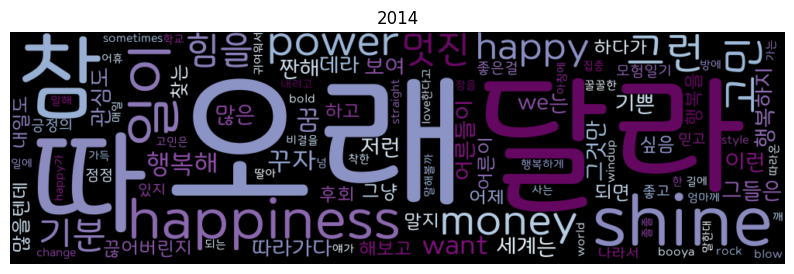

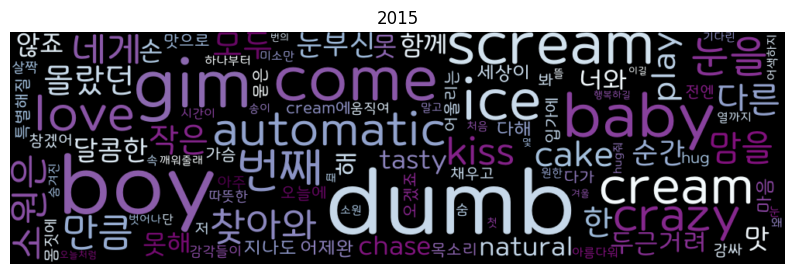

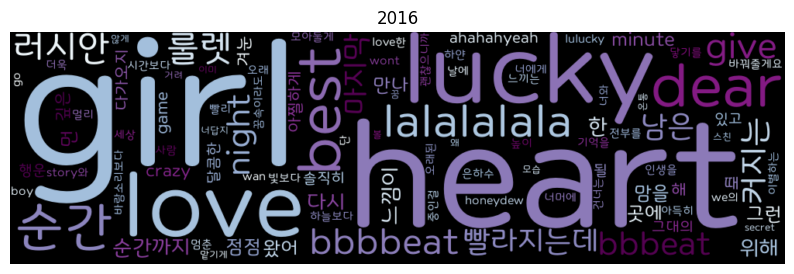

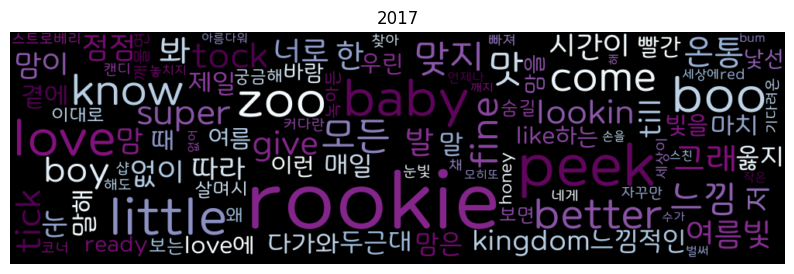

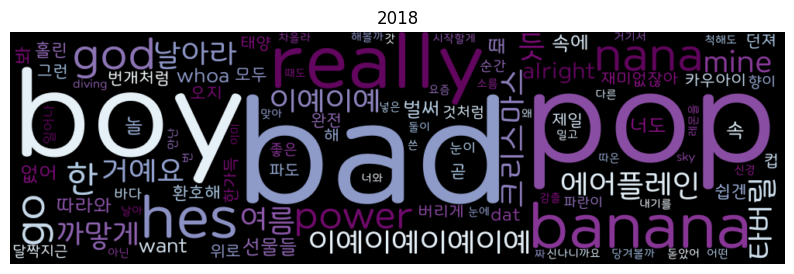

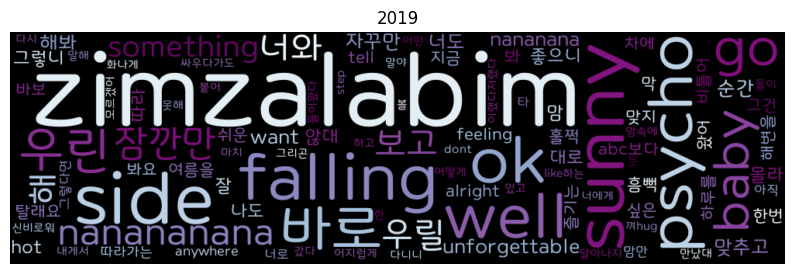

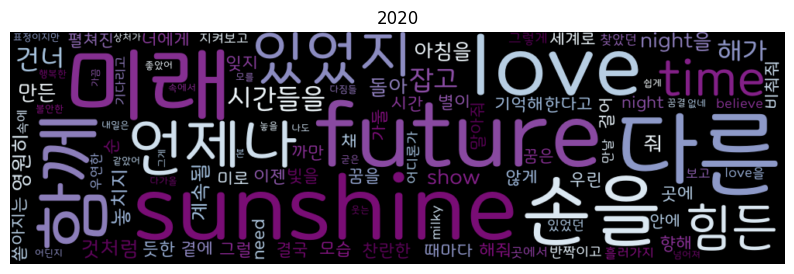

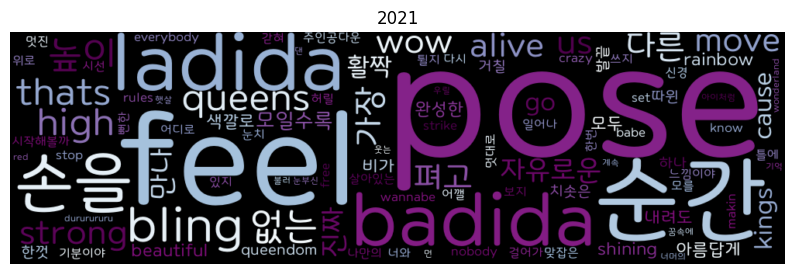

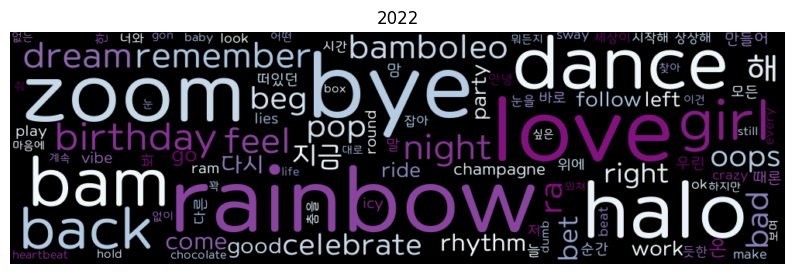

In [29]:
wordcloud_by_year(artist_id_)

## total wordcloud

In [30]:
# word_cloud_year(total_lyrics)

# n-gram

In [31]:
count_vec = CountVectorizer(ngram_range = (1,2))
tfidf = TfidfVectorizer(min_df = 0.1, max_df = 0.9, ngram_range=(2,3))

In [32]:
lyrics_vectorised = tfidf.fit_transform(df['final_lyrics'])
lyrics_vectorised_df = pd.DataFrame(
    lyrics_vectorised.toarray(),
    columns = tfidf.get_feature_names_out(),
    index = df['final_lyrics'].index)
lyrics_vectorised_df

,10까지 똑같은,10까지 똑같은 생각들을,1부터 10까지,1부터 10까지 똑같은,1분 1초,1분 1초 시간마저,1초 시간마저,1초 시간마저 아까워,1초도 지루한,1초도 지루한 no,...,힘든 현실,힘든 현실 완벽해,힘들었던 아침이,힘들었던 아침이 즐거울,힘을 내려고,힘을 내려고 windup,힘을 다해,힘을 다해 love을,힘을 믿고,힘을 믿고 있지
year,,,,,,,,,,,,,,,,,,,,,
2014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.037754,0.037754,0.000000,0.000000,0.075509,0.075509
2015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017,0.009169,0.009169,0.009169,0.009169,0.009169,0.009169,0.009169,0.009169,0.000000,0.000000,...,0.000000,0.000000,0.009169,0.009169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009253,0.009253,...,0.009253,0.009253,0.000000,0.000000,0.000000,0.000000,0.009253,0.009253,0.000000,0.000000


In [33]:
new_df = lyrics_vectorised_df.transpose()
new_df['sum'] = new_df[2019]+new_df[2020]+new_df[2021]+new_df[2022]
new_df

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,sum
10까지 똑같은,0.000000,0.0,0.0,0.009169,0.0,0.0,0.0,0.0,0.000000,0.000000
10까지 똑같은 생각들을,0.000000,0.0,0.0,0.009169,0.0,0.0,0.0,0.0,0.000000,0.000000
1부터 10까지,0.000000,0.0,0.0,0.009169,0.0,0.0,0.0,0.0,0.000000,0.000000
1부터 10까지 똑같은,0.000000,0.0,0.0,0.009169,0.0,0.0,0.0,0.0,0.000000,0.000000
1분 1초,0.000000,0.0,0.0,0.009169,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
힘을 내려고 windup,0.037754,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
힘을 다해,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.009253,0.009253
힘을 다해 love을,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.009253,0.009253
힘을 믿고,0.075509,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [34]:
new_df = new_df.reset_index()
new_df

year,index,2014,2015,2016,2017,2018,2019,2020,2021,2022,sum
0,10까지 똑같은,0.000000,0.0,0.0,0.009169,0.0,0.0,0.0,0.0,0.000000,0.000000
1,10까지 똑같은 생각들을,0.000000,0.0,0.0,0.009169,0.0,0.0,0.0,0.0,0.000000,0.000000
2,1부터 10까지,0.000000,0.0,0.0,0.009169,0.0,0.0,0.0,0.0,0.000000,0.000000
3,1부터 10까지 똑같은,0.000000,0.0,0.0,0.009169,0.0,0.0,0.0,0.0,0.000000,0.000000
4,1분 1초,0.000000,0.0,0.0,0.009169,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
11664,힘을 내려고 windup,0.037754,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
11665,힘을 다해,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.009253,0.009253
11666,힘을 다해 love을,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.009253,0.009253
11667,힘을 믿고,0.075509,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [35]:
a = new_df[new_df['index'].str.contains('boy')]
c = a[['index', 'sum']].sort_values(by='sum')
c.head(50)

year,index,sum
43,alright bad boy,0.0
2368,rookie boy,0.0
2369,rookie boy like,0.0
2370,rookie boy like질,0.0
2371,rookie boy man,0.0
2372,rookie boy 이토록,0.0
2376,rookie rookie boy,0.0
2667,trip 짓궂지 boy,0.0
2975,who dat boy,0.0
3012,would boy,0.0


## LDA

In [ ]:
n_components = 5
lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = 500)
lda_model.fit(lyrics_vectorised)

document_topic_mixture = lda_model.transform(lyrics_vectorised)
document_topic_mixture

In [ ]:
topic_word_mixture = pd.DataFrame(lda_model.components_, columns = tfidf.get_feature_names_out())
topic_word_mixture

In [ ]:
topic_word_mixture.loc[0].sort_values(ascending = False).head(10)

In [ ]:
topic_word_mixture.loc[1].sort_values(ascending = False).head(10)

In [ ]:
topic_word_mixture.loc[2].sort_values(ascending = False).head(10)

In [ ]:
topic_word_mixture.loc[3].sort_values(ascending = False).head(10)

In [ ]:
topic_word_mixture.loc[4].sort_values(ascending = False).head(10)

# word ranking

In [ ]:
def word_ranking(df_year):

    wordlist = df_year.split()
    wordfreq = [wordlist.count(p) for p in wordlist]
    freqdict = dict(list(zip(wordlist,wordfreq)))

    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    
    df = pd.DataFrame(aux)
    df = df.rename(columns = {0: 'frequency', 1:'keyword'})
    
    return df[:200]

In [ ]:
keyword_total = word_ranking(total_lyrics)
keyword_total

### plot

In [ ]:
keyword_25 = keyword_total[:25]
keyword_25

In [ ]:
sns.set_theme(style="whitegrid")
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False

# Initialize the matplotlib figure
plt.figure(figsize=(13,5))
plt.rcParams["font.family"] = "AppleGothic"

# Plot the total keywords
sns.set_color_codes("pastel")
sns.barplot(x="frequency", y="keyword", data=keyword_25, color="pink")

sns.despine(left=True, bottom=True)

# word frequency

In [ ]:
def word_by_years(text, word):
    num_of_word = text.count(word)
    len_of_df = len(text)
    ratio = num_of_word / len_of_df *100
    return round(ratio, 3)

In [ ]:
df['love'] = df.final_lyrics.apply(lambda x: word_by_years(x, "love"))
df['kiss'] = df.final_lyrics.apply(lambda x: word_by_years(x, "kiss"))
df['touch'] = df.final_lyrics.apply(lambda x: word_by_years(x, "touch"))
df['feel'] = df.final_lyrics.apply(lambda x: word_by_years(x, "feel"))
df['like'] = df.final_lyrics.apply(lambda x: word_by_years(x, "like"))
df['baby'] = df.final_lyrics.apply(lambda x: word_by_years(x, "baby"))
df['night'] = df.final_lyrics.apply(lambda x: word_by_years(x, "night"))
df['my'] = df.final_lyrics.apply(lambda x: word_by_years(x, "my"))
df['we'] = df.final_lyrics.apply(lambda x: word_by_years(x, "we"))

#female
df['so-nyo'] = df.final_lyrics.apply(lambda x: word_by_years(x, "nyeo"))
df['woman'] = df.final_lyrics.apply(lambda x: word_by_years(x, "woman"))
df['girl'] = df.final_lyrics.apply(lambda x: word_by_years(x, "girl"))
df['girls'] = df.final_lyrics.apply(lambda x: word_by_years(x, "girls"))
df['noona'] = df.final_lyrics.apply(lambda x: word_by_years(x, "noona"))
df['her'] = df.final_lyrics.apply(lambda x: word_by_years(x, "her"))
df['lady'] = df.final_lyrics.apply(lambda x: word_by_years(x, "lady"))

#male
df['he/him/his'] = df.final_lyrics.apply(lambda x: word_by_years(x, "him"))
df['guy'] = df.final_lyrics.apply(lambda x: word_by_years(x, "guy"))
df['boy'] = df.final_lyrics.apply(lambda x: word_by_years(x, "boy"))
df['man'] = df.final_lyrics.apply(lambda x: word_by_years(x, "man"))
df['oppa'] = df.final_lyrics.apply(lambda x: word_by_years(x, "oppa"))
df['mr'] = df.final_lyrics.apply(lambda x: word_by_years(x, "mr"))
                                                           
df['want'] = df.final_lyrics.apply(lambda x: word_by_years(x, "wan"))

## plot

In [ ]:
keywords_df = df.drop(columns=['final_lyrics'])

In [ ]:
keywords_df

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pandas import DataFrame

plt.figure(figsize = (30,10))


plt.plot(keywords_df['my'], label = 'my')
plt.plot(keywords_df['we'], label = 'we')

#love-related
plt.plot(keywords_df['love'], label = 'love', color = 'pink')
plt.plot(keywords_df['like'], label = 'like')
plt.plot(keywords_df['baby'], label = 'baby')
# plt.plot(keywords_df['kiss'], label = 'kiss')
# plt.plot(keywords_df['touch'], label = 'touch')
# plt.plot(keywords_df['feel'], label = 'feel')
plt.plot(keywords_df['night'], label = 'night', color = 'black')

## GIRLGROUP specific
plt.plot(keywords_df['he/him/his'], linestyle='dashed', label = 'he/him/his')
plt.plot(keywords_df['boy'], linestyle='dashed', label = 'boy')
plt.plot(keywords_df['man'], linestyle='dashed', label = 'man')
plt.plot(keywords_df['mr'], linestyle='dashed', label = 'mr')
plt.plot(keywords_df['girl'], label = 'girl') #mostly related to hetero-normative term
plt.plot(keywords_df['girls'], label = 'girls') #mostly related to women empowerment(girlhood)
# plt.plot(keywords_df['so-nyo'], label = 'sonyo') - not significant


## BOYGROUPS specific

# plt.plot(keywords_df['her'], label = 'her')
# plt.plot(keywords_df['girl'], label = 'girl')
# plt.plot(keywords_df['woman'], color='red', label = 'woman')
# plt.plot(keywords_df['girls'], label = 'girls')



## 보류

# plt.plot(keywords_df['want'], label = 'want')
# plt.plot(keywords_df['why'], label = 'why')

plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Keywords")
plt.show()

# TOTAL analysis (Girls vs Boys)

In [39]:
def clean_text(text):

    manual_sw = ['im', 'youre', "n't", '내', '나를', '나의', '너의', '난', '날', '내가', '너','나', '그', '니', '걸', '거야', '수', '다', '더',
'널', '네', '니가', '네가', '널', '너를', '넌', '내게', '이', 'l', 'u', '-',
'na', 'ah', 'e','m', 'uh', 'eh', 's', 'la', 'a', 'o', 'ta', 't', 'oh', 'du', 'yeah', '’', 'amp', 'comp',
'tu', 'ye', 'it', 'i', 'but', '너무', 'so', 'in', '또', 'roob', '왔니', '조금', '꼭', '이렇게',
'bo', 'peep', 'the','lolli', '정말', 'for', 'lollipop', '이제', 'on', 'muzik', 'lets', 'about', 
'처', 'amoled', '좀', '두', '닷닷닷닷닷', '어쩌다', '4', 'is', 'and', 'to', 'you', 'me','huh', 'now', 'ooop',
'just', 're', 'jumpin', 'dori', 'let', 'one', '아', 'ma', 'take', 'its', 'woo', 'this', 'that',
'whoo', 'get', 'are', 'dovey', 'hey', '어머어머', 'hush', '오', '나는', '너는', '슈가프리', '자꾸', '위', '아래', '것', '있어', '같아', '돼', 'ya', 'tickle', 'ha',
'way', '싶어', '같은', '오늘', '딱', '않아', '마', 'poppy','같아', 'day', 'be', 'rollin', '게', 'ba', 'hoo', 'ey', 'pa', 'ooh', 'swan', 'woo', 'ill', 'da', 'zu',
'zim', 'dam', 'dda', 'got', 'umpah','안', '건', '할','것도', 'at', 'yah', 'all', 'with', 'ae']


    #changing to lowercase
    text = text.lower()
    text = text.replace('\r','')

    # removing #´s 
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)

    #indentation -> space
    text = re.sub(r'\n', ' ', text)

    for punctuation in string.punctuation:
        text = text.replace(punctuation, '') 

    #strip
    text = text.strip()

    #tokenization
    tokens = word_tokenize(text)   
    filtered_words = [w for w in tokens if w not in manual_sw]
    final = " ".join(cat for cat in filtered_words)

    return final

def kor_to_eng(text):

    #love related
    text = text.replace("사랑", "love")
    text = text.replace("좋아", "like") # like has multiple meanings, so needs to n-gram as well
    text = text.replace("키스", "kiss")
    text = text.replace("입맞", "kiss")
    text = text.replace("뽀뽀", "kiss")
    text = text.replace("터치", 'touch')
    text = text.replace("안아", 'hug')
    text = text.replace("원해", "want")
    text = text.replace("원하", "want")
    text = text.replace("밤", "night")

    #pronouns
#         text = text.replace("내", "my")
    text = text.replace("나의", "my")
    text = text.replace('우리', 'we')

    #gender-specific
    text = text.replace("남자", "man")
    text = text.replace("소년", 'boy')
    text = text.replace("오빠", "oppa")
    text = text.replace("그의", 'him')
    text = text.replace("그에게", 'him')
    text = text.replace("그와", 'him')
    text = text.replace("그를", 'him')
    text = text.replace("그가", 'him')
    text = text.replace("그는", 'him')
    text = text.replace("놈", 'guy')

    text = text.replace("소녀", "nyeo") #young girl (少女)
    text = text.replace("여자", "woman")
    text = text.replace("그녀", 'her')

# want & girl should be dealt with n-grams because the meaning is completely different 
#between English and Korean
#돈 (money)

    return text


In [40]:
gg_df = pd.read_csv('gg_final_dataframe.csv')
gg_df = gg_df[['artist_x', 'song_name', 'year', 'Lyric']]

In [42]:
gg_df['cleaned_lyrics'] = gg_df.Lyric.apply(clean_text)
gg_df['final_lyrics'] = gg_df.cleaned_lyrics.apply(clean_text)
gg_df.drop(columns = ['Lyric', 'cleaned_lyrics'], inplace = True)

,artist_x,song_name,year,final_lyrics
0,SG워너비,Must Have Love (우리들의 겨울),2006,함께 있단 이유로 행복했었던 우리들의 겨울날의 소중한 기억들 좋은 날엔 언제나 있기...
1,브라운 아이드 걸스,어쩌다,2008,사랑하게 됐는지 왜 이꼴이 됐는지 맘 타버렸는지 이런 바보 였는지 이거 참 이럴줄은...
2,브라운 아이드 걸스,You,2008,그대는 바람과 같네 돌아와 baby feeling love feeling love ...
3,브라운 아이드 걸스,Abracadabra,2009,이러다 미쳐 여리 여리 착하던 그런 때문에 돌아 독한 나로 변해 닮은 인형에다 주문...
4,브라운 아이드 걸스,Candy Man,2009,캔디처럼 달콤한 숨이 멈출듯한 미소 몇번씩 몇번씩 무너지는거야 대체 fantasti...
...,...,...,...,...
1963,NewJeans,Attention,2022,맘이 보이지 한참을 쳐다봐 가까이 다가가 see see two three 용기가 생...
1964,NewJeans,Cookie,2022,만든 쿠키 위해 구웠지 know ain free 만든 쿠키 부드러우니 자꾸만 떠오르...
1965,NewJeans,Hurt,2022,보고 싶은 생각에 들어간 우리 창에 말을 거는데 보내지는 않을래 느린 한마디보다 조...
1966,NewJeans,Ditto,2023,stay middle like little dont want no riddle 말해...


In [41]:
bg_df = pd.read_csv('boygroup_final_dataframe2.csv', index_col = 'artist_id')
bg_df = bg_df[['artist_x', 'song_name', 'year', 'Lyric']]

In [43]:
bg_df['cleaned_lyrics'] = bg_df.Lyric.apply(clean_text)
bg_df['final_lyrics'] = bg_df.cleaned_lyrics.apply(clean_text)
bg_df.drop(columns = ['Lyric', 'cleaned_lyrics'], inplace = True)

## by_year

In [44]:
by_year_g = gg_df.groupby(['year']).sum()[['final_lyrics']]
by_year_b = bg_df.groupby(['year']).sum()[['final_lyrics']]

## ngram

In [45]:
count_vec = CountVectorizer(ngram_range = (1,2))
tfidf = TfidfVectorizer(min_df = 0.1, max_df = 0.9, ngram_range=(2,3))

### girls

In [48]:
lyrics_vectorised = tfidf.fit_transform(by_year_g['final_lyrics'])
lyrics_vectorised_df = pd.DataFrame(
    lyrics_vectorised.toarray(),
    columns = tfidf.get_feature_names_out(),
    index = by_year_g['final_lyrics'].index)


new_df_g = lyrics_vectorised_df.transpose()
new_df_g['sum'] = new_df_g[2019]+new_df_g[2020]+new_df_g[2021]+new_df_g[2022]
new_df_g = new_df_g.reset_index()


#replace 'love' with something else
lyrics_contains = new_df_g[new_df_g['index'].str.contains('love')]
c = lyrics_contains[['index', 'sum']].sort_values(by='sum', ascending = False)
c.head(50)

year,index,sum
3784,love love,0.495296
3789,love love love,0.282449
4007,lovesick girls,0.174828
7451,your love,0.114894
5950,stop love,0.102862
3134,kill love,0.089191
6982,we lovesick girls,0.085759
3882,love where,0.085759
6981,we lovesick,0.085759
3819,love myself,0.083773


### boys

In [49]:
lyrics_vectorised = tfidf.fit_transform(by_year_b['final_lyrics'])
lyrics_vectorised_df = pd.DataFrame(
    lyrics_vectorised.toarray(),
    columns = tfidf.get_feature_names_out(),
    index = by_year_b['final_lyrics'].index)


new_df_b = lyrics_vectorised_df.transpose()
new_df_b['sum'] = new_df_b[2019]+new_df_b[2020]+new_df_b[2021]+new_df_b[2022]
new_df_b = new_df_b.reset_index()


#replace 'love' with something else
lyrics_contains = new_df_b[new_df_b['index'].str.contains('love')]
c = lyrics_contains[['index', 'sum']].sort_values(by='sum', ascending = False)
c.head(50)

year,index,sum
1609,love love,0.367802
768,down your love,0.341649
3265,your love,0.252422
1611,love love love,0.163293
1856,my love,0.127148
2376,say love,0.111542
1617,love my,0.090152
2897,want love,0.087251
2365,savage love,0.084359
2899,want love want,0.078842
